# Supply Visualization Class

## Import packages

In [115]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree
import imageio
from datetime import datetime
from pytz import timezone
import pytz

## Class implementation

In [279]:
class GHIVisualization():
    def __init__(self, year: str):
        assert isinstance(year, str) and len(year) == 4, f'year should be a four digits string. e.g \'2018\''
        self.year = year
        
    def load_data(self):
        '''
        Load NSRDB dataset from https://data.openei.org/s3_viewer?bucket=nrel-pds-nsrdb&prefix=v3%2F
        Returns:
            f (h5pyd file): NSRDB file
            meta (pandas.DataFrame): Contains information of every state
            time_index (pandas.DataFrame): Time index for the year
            coords (numpy.ndarray): The whole coordinates in the dataset
        '''
        path = f"/nrel/nsrdb/v3/nsrdb_{self.year}.h5"
        print(f'Loading {self.year} NSRDB dataset...')
        f = h5pyd.File(path, 'r')
        print(f'Successfully loading {self.year} NSRDB dataset!')
        
        # Get time index
        time_index = pd.to_datetime(f['time_index'][:].astype(str))
        print(f'Successfully loading time index dataset!')
        
        # Get every coordinates of the dataset
        coords = f['coordinates'][:]
        print(f'Successfully loading coordinates dataset!')
        
        # Full resolution subset
        print(f"Loading meta data...")
        meta = pd.DataFrame(f['meta'][:])
        print(f'Successfully loading meta dataset!')
        
        return f, meta, time_index, coords
    
    def load_state_data(self, f, meta, state_name):
        '''
        Load the given state data from the NSRDB file
        Args:
            f (h5pyd): nsrdb file
            meta (pandas.DataFrame): Contains information of every state
            state_name (string): state name e.g. 'California'
        Returns:
            state_data (pandas.DataFrame): the dataset of the state
            state_tseries: the whold time series of the state
        '''
        # Check if the given state name is in the dataset
        if state_name.encode('ASCII') not in meta['state'].unique():
            raise KeyError(f'{state_name} is not in {f}. Check with: state_name.encode(\'ASCII\') in meta[\'state\'].unique()')
        
        print(f"Loading {state_name} data...")
        state_data = meta.loc[meta['state'] == state_name.encode('ASCII')] # Note .h5 saves strings as bit-strings
        print(f"Done!")
        
        # Get the index of the state coordinates in coords
        state_index = np.array(state_data.index)
        
        # Get the sum of GHI of the state (get one coordinate every 10)
        print(f'Loading the whole state time series...')
        state_tseries = np.sum(f['ghi'][:, state_index[::10]] / f['ghi'].attrs['psm_scale_factor'], axis=1)
        print(f'Done!')
        
        return state_data, state_tseries
        
    def plot_all_ghi_heatmap(self, f, timestamp, coords, file_name=None, save=False):
        '''
        Plot the GHI of the whold coordinates in the dataset at a certain timestamp
        Args:
            f (h5pyd): nsrdb file
            timestamp (string): certain time (UTC) to plot, need to be the same year as the input file f. e.g '2018-12-24 12:00:00'
            coords (numpy.ndarray): coordiantes in the dataset. (coords = f['coordinates'][:])
            data (numpy.ndarray): GHI of every coordinates at the timestamp (data = f['ghi'][timestep, ::10]   # extract ghi for every 10th location at a particular time)
            file_name (string): file name to save the plotted figure
            save (boolean): True to save, False otherwise. (Default True)
        Returns:
            df (pandas.DataFrame): the dataframe contains longitude, latitude and GHI
        '''
        assert timestamp.split(' ')[0].split('-')[0] == self.year, f'Need to use the same year as the load file'
        
        # Get time index for that year
        time_index = pd.to_datetime(f['time_index'][...].astype(str))
        
        # Get the index of given timestamp
        timestep = np.where(time_index == timestamp)[0][0]
        
        # Get all ghi data
        print(f'Getting all GHI values...')
        all_ghi = f['ghi'][timestep, ::10]
        print(f'Done!')
        
        # Combine data (GHI) with coordinates into a DataFrame
        df = pd.DataFrame() 
        df['longitude'] = coords[::10, 1]
        df['latitude'] = coords[::10, 0]
        df['ghi'] = all_ghi / f['ghi'].attrs['psm_scale_factor'] # unscale dataset
        
        df.plot.scatter(x='longitude', y='latitude', c='ghi',
            colormap='YlOrRd',
            title=str(time_index[timestep]) + ' UTC')
        
        # Save the figure
        if save:
            plt.savefig(file_name)
            print(f'Save the figure to /{file_name}')
        
        print(f'GHI at {str(time_index[timestep])} UTC')
        plt.show()
        return df
        
    def plot_state_ghi_heatmap(self, f, timestamp, state_data, file_name=None, save=False):
        '''
        Plot the heatmap of the GHI of given state at a certain timestamp
        Args:
            f (h5pyd): nsrdb file
            timestamp (string): certain time (UTC) to plot. e.g '2018-12-24 14:00:00'
            state_data (pandas.DataFrame): state data from load_state_data()
            file_name (string): file name to save the plotted figure
            save (boolean): True to save, False otherwise. (Default False)
        Return:
            df (pandas.DataFrame): A pandas.DataFrame contains the info of the state and GHI
        '''
        assert timestamp.split(' ')[0].split('-')[0] == self.year, f'Need to use the same year as the load file.'
        if save:
            assert file_name != None, f'Need file name for saving.'
        
        # Get time index for that year
        time_index = pd.to_datetime(f['time_index'][...].astype(str))
        
        # Get the index of given timestamp
        timestamp_index = np.where(time_index == timestamp)[0][0]
        
        # Get the GHI of the state at the given timestamp
        print(f'Loading GHI...')
        state_ghi = f['ghi'][timestamp_index][state_data.index]  # full-resolution subset
        print(f'Done!')
        
        # Get the longitude and latitude of the state at the given timestamp
        df = state_data[['longitude', 'latitude', 'country', 'state', 'county']].copy()
        
        # Get the GHI of every coordinates (longitude, latitude) in the state
        df['ghi'] = state_ghi / f['ghi'].attrs['psm_scale_factor'] 
        
        # Plot the map
        df.plot.scatter(x='longitude', y='latitude', c='ghi',
                    colormap='YlOrRd',
                    title=str(time_index[timestamp_index]) + ' UTC')
        
        # Save the figure
        if save:
            plt.savefig(file_name)
            print(f'Save the figure to /{file_name}')

        return df
            
    def plot_one_coord_ghi(self, f, state_name, coords, lat_coord, lon_coord, file_name=None, save=False):
        '''
        Plot the ghi of the given latitude and longitude
        Args:
            f (h5pyd): nsrdb file
            state_name (string): to print in the figure
            coords: coordinates of the dataset
            lat_coord: given latitude
            lon_coord: given longitude
        Returns:
            df (pandas.DataFrame): A pandas.DataFrame contains the info of the timestamp and GHI
        '''
        if save:
            assert file_name != None, f'Need file name for saving.'
            
        tree = cKDTree(coords)
        def nearest_site(tree, lat_coord, lon_coord):
            lat_lon = np.array([lat_coord, lon_coord])
            dist, pos = tree.query(lat_lon)
            return pos

        coord = (lat_coord, lon_coord)
        # Get the nearest state index in coords
        state_idx = nearest_site(tree, coord[0], coord[1])

        print("Site index: \t\t {}".format(state_idx))
        print("Input coordinates: \t {}".format(coord))
        print("Nearest coordinates: \t {}".format(coords[state_idx]))
        
        # Get the entire 2018 timeseries data for a point in San Diego (Skip one every two to get match the demand dataset)
        tseries = f['ghi'][:, state_idx] / f['ghi'].attrs['psm_scale_factor']
        
        # Plot the ghi across the year in given coordinate
        plt.plot(time_index[:], tseries)
        plt.ylabel("GHI (W/m2)")
        plt.title(f"{state_name} GHI in {self.year}")
        if save:
            plt.savefig(file_name)
        
        df = pd.DataFrame({'Time':time_index[::1], 'GHI': tseries})
        return df
    
    def plot_state_GHI_in_one_year(self, f, state_data, time_index, state_tseries, file_name=None, save=False):
        '''
        Plot the GHI of the given state in the given year
        Args:
            f (h5pyd): nsrdb file
            state_data (pandas.DataFrame): state data from load_state_data()
            time_index: time index from load_data()
            file_name (string): path to save the figure
            save (boolean): True to save, False otherwise. (Default True)
        Returns:
            pd.DataFrame
        '''
        if save:
            assert file_name != None, f'Need file name for saving.'
        
        # Get state name
        state_name = list(state_data['state'])[0]
        state_name = str(state_name, encoding='utf-8')
        
        # Plot
        plt.plot(time_index[:], state_tseries, '-')
        plt.ylabel("GHI (W)")
        plt.title(f"{state_name} GHI in {self.year}")
        file_name = f'{state_name}_GHI_in_{self.year}.jpg'
        
        if save:
            plt.savefig(file_name)
            print(f'Save the figure to /{file_name}')
        
        df = pd.DataFrame({'Time': time_index, 'GHI': state_tseries})
        return df
    
    def plot_state_month_hour_heatmap(self, f, state_data, state_tseries, file_name=None, save=False):
        '''
        Plot month-hour heatmap for given state
        Args:
            f (h5pyd): nsrdb file
            state_data (pandas.DataFrame): state data from load_state_data()
            state_tseries (array): sum of GHI of the state from load_state_data()
            file_name (string): path to save the figure
            save (boolean): True to save, False otherwise. (Default True)
        Returns:
            pd.DataFrame
        '''
        if save:
            assert file_name != None, f'Need file name for saving.'
        # Get the coordinates of the state
        df = state_data[['longitude', 'latitude']].copy()
        
        df = pd.DataFrame({'ghi': state_tseries}, index=time_index)
        df["year"] = df.index.year
        df["month"] = df.index.month
        df["day"] = df.index.day
        df["hour"] = df.index.hour
        
        # Get GHI by each hour and month
        agg = df.groupby(["month", "hour"]).mean()
        agg = agg.reset_index().pivot(index="month", columns='hour', values="ghi")
        
        # Get state name
        state_name = list(state_data['state'])[0]
        state_name = str(state_name, encoding='utf-8')
        
        # Plot the Heat Map
        plt.imshow(agg)
        plt.xlabel("Hour")
        plt.ylabel("Month")
        plt.title(f'{self.year} Mean GHI in {state_name} (W/m^2)')
        plt.colorbar()
        if save:
            plt.savefig(file_name)
            print(f'Save the figure to /{file_name}')
        
        return agg
    
    def plot_state_variance(self, f, state_data, state_tseries, file_name=None, save=False):
        '''
        Plot the GHI variance of the state
        Args:
            f (h5pyd): nsrdb file
            state_data (pandas.DataFrame): state data from load_state_data()
            state_tseries (array): sum of GHI of the state from load_state_data()
            file_name (string): path to save the figure
            save (boolean): True to save, False otherwise. (Default True)
        Returns:
            pd.DataFrame
        '''
        if save:
            assert file_name != None, f'Need file name for saving.'
        # Get the coordinates of the state
        df = state_data[['longitude', 'latitude']].copy()
        
        df = pd.DataFrame({'ghi': state_tseries}, index=time_index)
        df["year"] = df.index.year
        df["month"] = df.index.month
        df["day"] = df.index.day
        df["hour"] = df.index.hour
        
        # Get the sum of GHI in a day for every month
        agg_sum = df.groupby(["month", "day"]).sum()
        agg_sum = agg_sum.reset_index().pivot(index="day",columns="month",values="ghi")
        
        # Get state name
        state_name = list(state_data['state'])[0]
        state_name = str(state_name, encoding='utf-8')
        
        # Get the boxplot
        plt.figure()
        agg_sum.boxplot(column=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
        plt.title(f'Variation per month in GHI in {state_name} ({self.year})')
        plt.xlabel('Month')
        plt.ylabel('GHI (W/m2)')
        
        # Save the figure
        if save:
            plt.savefig(file_name)
            print(f'Save the figure to /{file_name}')
            
        return agg_sum
    
    def plot_state_GHI_by_month(self, f, state_data, state_tseries, months, file_name=None, save=False):
        '''
        Plot the GHI by days of given months
        Args:
            f (h5pyd): nsrdb file
            state_data (pandas.DataFrame): state data from load_state_data()
            state_tseries (array): sum of GHI of the state from load_state_data()
            months (list(int)): months to plot, from 1 to 12. e.g [1, 2, 6, 7, 8, 12]
            file_name (string): path to save the figure
            save (boolean): True to save, False otherwise. (Default True)
        Returns:
            pd.DataFrame
        '''
        if save:
            assert file_name != None, f'Need file name for saving.'
        # Get the coordinates of the state
        df = state_data[['longitude', 'latitude']].copy()
        
        df = pd.DataFrame({'ghi': state_tseries}, index=time_index)
        df["year"] = df.index.year
        df["month"] = df.index.month
        df["day"] = df.index.day
        df["hour"] = df.index.hour
        
        # Get the sum of GHI in a day for every month
        agg_sum = df.groupby(["month", "day"]).sum()
        agg_sum = agg_sum.reset_index().pivot(index="day",columns="month",values="ghi")
        
        # Get state name
        state_name = list(state_data['state'])[0]
        state_name = str(state_name, encoding='utf-8')
        
        # Plot
        plt.figure()
        agg_sum[months].plot(style='-')
        plt.title(f'Months GHI in {state_name} ({self.year})')
        plt.xlabel('Day')
        plt.ylabel('GHI (W/m2)')
        
        # Save the figure
        if save:
            plt.savefig(file_name)
            print(f'Save the figure to /{file_name}')
            
        return agg_sum[months]
        

In [280]:
s = GHIVisualization('2019')

In [281]:
s.year

'2019'

In [282]:
f, meta, time_index, coords = s.load_data()

Loading 2019 NSRDB dataset...
Successfully loading 2019 NSRDB dataset!
Successfully loading time index dataset!
Successfully loading coordinates dataset!
Loading meta data...
Successfully loading meta dataset!


In [283]:
california_data, california_tseries = s.load_state_data(f, meta, 'California')

Loading California data...
Done!
Loading the whole state time series...
Done!


In [268]:
california_data

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
70276,32.529999,-117.099998,55.062500,-8,b'United States',b'California',b'San Diego',b'None',32326,130
70588,32.570000,-117.099998,7.100000,-8,b'United States',b'California',b'San Diego',b'Tijuana',27971,190
70589,32.570000,-117.059998,24.920000,-8,b'United States',b'California',b'San Diego',b'Tijuana',51608,190
70590,32.570000,-117.019997,96.599998,-8,b'United States',b'California',b'San Diego',b'Tijuana',15236,110
70591,32.570000,-116.980003,140.600006,-8,b'United States',b'California',b'San Diego',b'Tijuana',2949,130
...,...,...,...,...,...,...,...,...,...,...
172687,41.970001,-120.180000,2289.360107,-8,b'United States',b'California',b'Modoc',b'None',0,70
172688,41.970001,-120.139999,2276.080078,-8,b'United States',b'California',b'Modoc',b'None',0,70
172689,41.970001,-120.099998,2039.900024,-8,b'United States',b'California',b'Modoc',b'None',0,70
172690,41.970001,-120.059998,1775.760010,-8,b'United States',b'California',b'Modoc',b'None',0,70


In [269]:
# Sum of GHI through the year
california_tseries

array([217887.,  88144.,   3101., ..., 811856., 622017., 426110.])

In [270]:
time_index

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 00:30:00',
               '2019-01-01 01:00:00', '2019-01-01 01:30:00',
               '2019-01-01 02:00:00', '2019-01-01 02:30:00',
               '2019-01-01 03:00:00', '2019-01-01 03:30:00',
               '2019-01-01 04:00:00', '2019-01-01 04:30:00',
               ...
               '2019-12-31 19:00:00', '2019-12-31 19:30:00',
               '2019-12-31 20:00:00', '2019-12-31 20:30:00',
               '2019-12-31 21:00:00', '2019-12-31 21:30:00',
               '2019-12-31 22:00:00', '2019-12-31 22:30:00',
               '2019-12-31 23:00:00', '2019-12-31 23:30:00'],
              dtype='datetime64[ns]', length=17520, freq=None)

Getting all GHI values...
Done!
GHI at 2019-12-24 17:00:00 UTC


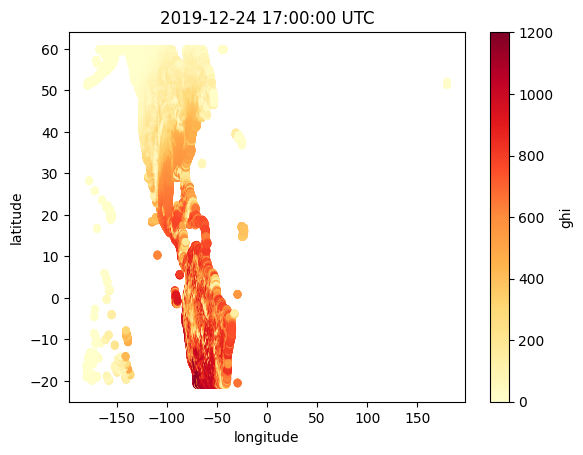

In [221]:
timestamp = '2019-12-24 17:00:00'
df_all_ghi_heatmap = s.plot_all_ghi_heatmap(f, timestamp, coords, file_name=None, save=False)

In [222]:
df_all_ghi_heatmap

,longitude,latitude,ghi
0,-175.259995,-19.990000,5.0
1,-174.860001,-19.990000,3.0
2,-174.179993,-19.990000,4.0
3,-158.139999,-19.990000,142.0
4,-157.740005,-19.990000,134.0
...,...,...,...
201835,179.740005,51.930000,8.0
201836,179.779999,52.009998,8.0
201837,179.779999,52.169998,8.0
201838,179.820007,51.689999,8.0


Loading GHI...
Done!


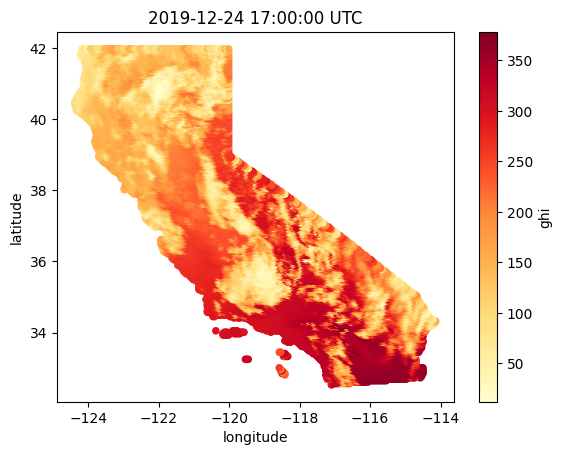

In [223]:
timestamp = '2019-12-24 17:00:00'
df_state_ghi_heatmap = s.plot_state_ghi_heatmap(f, timestamp, california_data, file_name=None, save=False)

In [224]:
df_state_ghi_heatmap

,longitude,latitude,country,state,county,ghi
70276,-117.099998,32.529999,b'United States',b'California',b'San Diego',309.0
70588,-117.099998,32.570000,b'United States',b'California',b'San Diego',283.0
70589,-117.059998,32.570000,b'United States',b'California',b'San Diego',344.0
70590,-117.019997,32.570000,b'United States',b'California',b'San Diego',346.0
70591,-116.980003,32.570000,b'United States',b'California',b'San Diego',347.0
...,...,...,...,...,...,...
172687,-120.180000,41.970001,b'United States',b'California',b'Modoc',85.0
172688,-120.139999,41.970001,b'United States',b'California',b'Modoc',129.0
172689,-120.099998,41.970001,b'United States',b'California',b'Modoc',155.0
172690,-120.059998,41.970001,b'United States',b'California',b'Modoc',80.0


Site index: 		 71886
Input coordinates: 	 (32.715736, -117.161087)
Nearest coordinates: 	 [  32.73 -117.18]


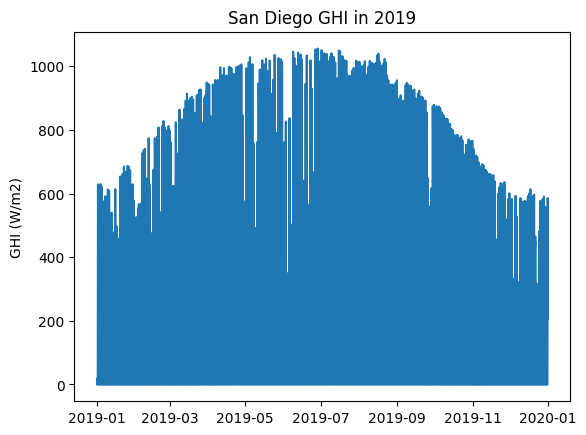

In [225]:
df_one_coord_ghi = s.plot_one_coord_ghi(f, 'San Diego', coords, 32.715736, -117.161087, file_name=None, save=False)

In [226]:
df_one_coord_ghi

,Time,GHI
0,2019-01-01 00:00:00,18.0
1,2019-01-01 00:30:00,10.0
2,2019-01-01 01:00:00,2.0
3,2019-01-01 01:30:00,0.0
4,2019-01-01 02:00:00,0.0
...,...,...
17515,2019-12-31 21:30:00,501.0
17516,2019-12-31 22:00:00,443.0
17517,2019-12-31 22:30:00,373.0
17518,2019-12-31 23:00:00,294.0


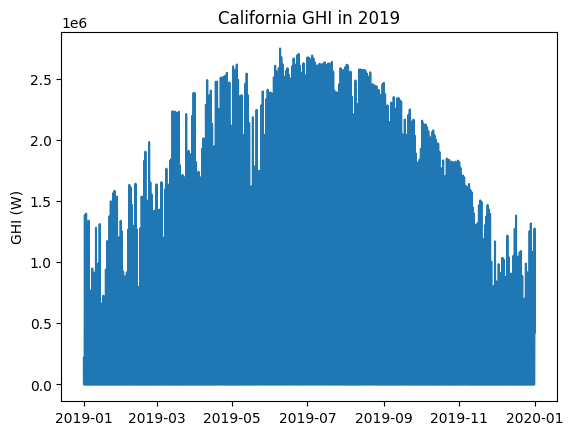

In [271]:
df_state_GHI_in_one_year = s.plot_state_GHI_in_one_year(f, california_data, time_index, california_tseries, file_name=None, save=False)

In [272]:
df_state_GHI_in_one_year

,Time,GHI
0,2019-01-01 00:00:00,217887.0
1,2019-01-01 00:30:00,88144.0
2,2019-01-01 01:00:00,3101.0
3,2019-01-01 01:30:00,0.0
4,2019-01-01 02:00:00,0.0
...,...,...
17515,2019-12-31 21:30:00,1096850.0
17516,2019-12-31 22:00:00,972289.0
17517,2019-12-31 22:30:00,811856.0
17518,2019-12-31 23:00:00,622017.0


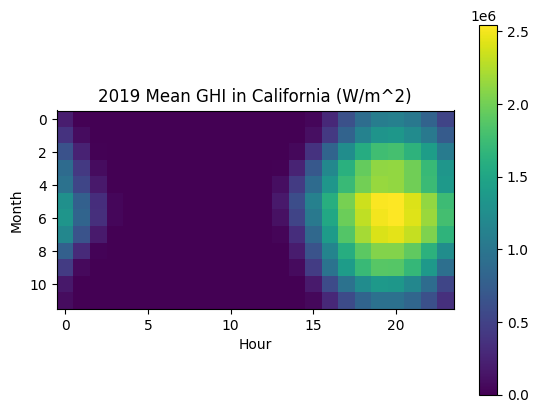

In [273]:
df_state_month_hour_heatmap = s.plot_state_month_hour_heatmap(f, california_data, california_tseries, file_name=None, save=False)

In [274]:
df_state_month_hour_heatmap

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
month,,,,,,,,,,,,,,,,,,,,,
1,2.014867e+05,12492.483871,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,6.209677,4.474432e+04,2.929483e+05,6.277038e+05,9.095188e+05,1.078419e+06,1.112089e+06,1.016734e+06,8.096953e+05,5.188182e+05
2,3.769820e+05,81914.642857,212.446429,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,2081.928571,1.016494e+05,4.201960e+05,8.102499e+05,1.130205e+06,1.319377e+06,1.346323e+06,1.225508e+06,1.023711e+06,7.272954e+05
3,6.367886e+05,240199.451613,16133.112903,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,59457.483871,3.729165e+05,8.185263e+05,1.245645e+06,1.577624e+06,1.765986e+06,1.792593e+06,1.649351e+06,1.412125e+06,1.063059e+06
4,8.855915e+05,426108.216667,84567.183333,537.666667,0.000000,0.0,0.0,0.0,0.0,0.0,...,250419.383333,7.050753e+05,1.191561e+06,1.615955e+06,1.941958e+06,2.118403e+06,2.132475e+06,1.989552e+06,1.715300e+06,1.338264e+06
5,9.553286e+05,526747.822581,170049.403226,9480.854839,0.000000,0.0,0.0,0.0,0.0,0.0,...,441451.225806,8.928955e+05,1.336472e+06,1.722438e+06,1.999153e+06,2.147335e+06,2.133822e+06,1.993745e+06,1.736208e+06,1.380676e+06
6,1.273448e+06,783557.683333,328955.900000,44807.316667,3.283333,0.0,0.0,0.0,0.0,0.0,...,603372.433333,1.113478e+06,1.597394e+06,2.026721e+06,2.347168e+06,2.527274e+06,2.544057e+06,2.409825e+06,2.136581e+06,1.748690e+06
7,1.324530e+06,822777.903226,345572.951613,43421.758065,1.354839,0.0,0.0,0.0,0.0,0.0,...,519155.129032,1.027152e+06,1.529704e+06,1.972839e+06,2.304797e+06,2.499412e+06,2.535570e+06,2.415724e+06,2.156798e+06,1.781404e+06
8,1.177514e+06,650641.096774,188752.758065,7008.951613,0.000000,0.0,0.0,0.0,0.0,0.0,...,330348.500000,8.565018e+05,1.398654e+06,1.859309e+06,2.201966e+06,2.402246e+06,2.439476e+06,2.316230e+06,2.048520e+06,1.655631e+06
9,7.823099e+05,306531.733333,27655.816667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,189443.950000,6.514143e+05,1.149834e+06,1.585065e+06,1.903970e+06,2.069987e+06,2.075311e+06,1.922929e+06,1.638627e+06,1.243379e+06


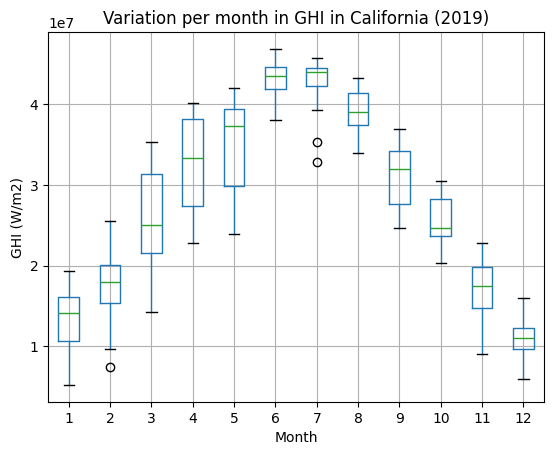

In [275]:
df_state_variance = s.plot_state_variance(f, california_data, california_tseries, file_name=None, save=False)

In [276]:
df_state_variance

month,1,2,3,4,5,6,7,8,9,10,11,12
day,,,,,,,,,,,,
1,16034858.0,11477004.0,18247619.0,26510591.0,41304770.0,39286472.0,45634509.0,43290746.0,36892755.0,30509931.0,22844115.0,9118401.0
2,16342451.0,7455638.0,15159848.0,24439594.0,41140659.0,38019756.0,45752049.0,43124834.0,32887643.0,30313129.0,21735286.0,11091235.0
3,14987447.0,10997632.0,19483044.0,26177438.0,41184850.0,41334585.0,44743561.0,41584189.0,34569638.0,29517286.0,21801141.0,10355043.0
4,15534479.0,11125080.0,21905906.0,24171647.0,42025606.0,43685104.0,45618834.0,41704054.0,32846654.0,29837328.0,21654170.0,5967310.0
5,5220233.0,15432016.0,14214269.0,22776605.0,39916467.0,43472136.0,45311941.0,39075307.0,27604690.0,29576122.0,20653269.0,11911900.0
6,8741393.0,20038607.0,15122565.0,27864585.0,36079894.0,41752028.0,44575689.0,33952622.0,34422714.0,29089138.0,20251444.0,11382883.0
7,10893204.0,20178004.0,20966953.0,29326863.0,37337366.0,44101982.0,40447764.0,36111847.0,32697932.0,28119885.0,19722331.0,7355093.0
8,10354980.0,17886893.0,23686458.0,25634344.0,37940778.0,46882240.0,43655921.0,39957815.0,35276435.0,27106196.0,20558867.0,10452993.0
9,10549222.0,14974663.0,21348308.0,32831673.0,33361358.0,45507439.0,42228852.0,38188635.0,33860067.0,28397656.0,19856334.0,14326573.0


<Figure size 640x480 with 0 Axes>

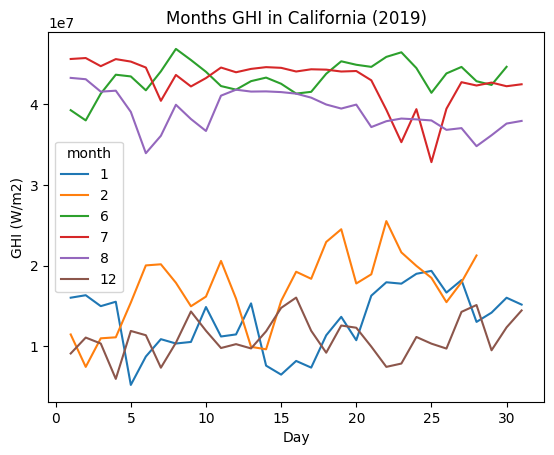

In [284]:
months = [1, 2, 6, 7, 8, 12]
df_state_GHI_by_month = s.plot_state_GHI_by_month(f, california_data, california_tseries, months, file_name=None, save=False)

In [285]:
df_state_GHI_by_month

month,1,2,6,7,8,12
day,,,,,,
1,16034858.0,11477004.0,39286472.0,45634509.0,43290746.0,9118401.0
2,16342451.0,7455638.0,38019756.0,45752049.0,43124834.0,11091235.0
3,14987447.0,10997632.0,41334585.0,44743561.0,41584189.0,10355043.0
4,15534479.0,11125080.0,43685104.0,45618834.0,41704054.0,5967310.0
5,5220233.0,15432016.0,43472136.0,45311941.0,39075307.0,11911900.0
6,8741393.0,20038607.0,41752028.0,44575689.0,33952622.0,11382883.0
7,10893204.0,20178004.0,44101982.0,40447764.0,36111847.0,7355093.0
8,10354980.0,17886893.0,46882240.0,43655921.0,39957815.0,10452993.0
9,10549222.0,14974663.0,45507439.0,42228852.0,38188635.0,14326573.0
